## Multivariate Normal Distribution

This lecture describes a workhorse in probability theory, statistics, and economics, namely, the __multivariate normal distribution__. The key concepts in this lecture include:

* the joint distribution of a random vector $x$ of length $N$
* marginal distributions of all subvectors of $x$
* conditional distributions for subvectors of $x$ conditional on other subvectors of $x$

A random variable $X$ is normally distributed with mean $\mu$  and variance $\sigma^2$ if it has the probability density function of $X$ as:

$$\phi(x) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \{ - \frac{1}{2 \sigma^2} (x - \mu)^2 \}$$

The multivariate normal distribution is a multidimensional generalisation of the one-dimensional normal distribution . It represents the distribution of a __multivariate random variable__ that is made up of multiple random variables that can be _correlated with eachother_.

Assume that an $N \times 1$ random vector $z$ has a multivariate normal probability density. This means that the probability density takes the form

$$f(z; \mu , \Sigma) = (\frac{1}{2\pi})^{N/2} |\Sigma)|^{-\frac{1}{2}} \exp\{- \frac{1}{2} (z- \mu)' \Sigma^{-1} (z-\mu)\}$$
$|\Sigma|$ denotes the determinant of the variance-covariance matrix $\Sigma$ and $\Sigma^{-1}$. 

The shorthand notation, similar to the univariate version is

$$X \sim N(\mu, \Sigma)$$

For mulvariate normal distribution, we still assume the random vector is i.i.d, which means:

* each row vector is independent and identifically distributed

Some things to note about the multivariate normal distribution:

The following term appearing inside the exponent of the multivariate normal distribution is a quadratic form:

$$(x - \mu)' \Sigma^{-1}(x- \mu)$$

If the variables are uncorrelated then the variance-covariance matrix will be a diagonal matrix with variances of the individual variables appearing on the main diagonal of the matrix and zeros everywhere else:

$$\Sigma = \begin{pmatrix} \sigma_1^2 & 0 & \cdots \\
0 & \sigma_2^2 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & \sigma_N^2 
\end{pmatrix}$$

We could also consider linear combinations of the elements of a multivariate normal random variable as shown in the expression below:

$$Y = \sum_{j=1}^N c_j X_j = c'X$$

Properties: 

* Each single variable has a univariate normal distribution. Thus we can look at univariate tests of normality for each variable when assessing multivariate normality.
* Any subset of the variables also has a multivariate normal distribution.
* Any linear combination of the variables has a univariate normal distribution.
* Any conditional distribution for a subset of the variables conditional on known values for another subset of variables is a multivariate distribution.

In [4]:
import numpy as np
from numba import njit
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
@njit

def f(z, mu, sigma):
    """
    The density function of multivariate normal distribution.
    
    Parameters:
    ---------------
    z: ndarray(float, dim=2)
        random vector, N by 1
    mu: ndarray(float, dim=1 or 2)
        the mean of z, N by 1
    sigma: ndarray(float, dim=2)
        the covariance matrix of z, N by N
    """
    
    z = np.atleast_2d(z)
    mu = np.atleast_2d(mu)
    sigma = np.atleast_2d(sigma)
    
    N = z.size
    
    temp1 = np.linalg.det(sigma) ** (-1/2)
    temp2 = np.exp(-0.5 * (z-mu).T @ np.linalg.inv(sigma) @ (z-mu))
    
    return (2 * np.pi)**(-N/2) * temp1 * temp2  # a scalar

For a partition $z$ as $z = \begin{bmatrix}z_1 \\ z_2 \end{bmatrix}$, where $z_1$ is an $(N-k)\times 1$ vector and $z_2$ is a $k \times 1$ vecotor.
Let 
$$\mu = \begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \ \ \Sigma = \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22} \end{bmatrix}$$

be corresponding partitions of $\mu$ and $\Sigma$. 

The _marginal_ distribution of $z_1$ is

* multivariate normal with mean $\mu_1$ and covariance matrix $\Sigma_{11}$

The _marginal_ distribution of $z_2$ is

* multivariate normal with mean $\mu_2$ and covariance matrix $\Sigma_{22}$

The distribution of $z_1$ _conditonal_ on $z_2$ is

* multivariate normal with mean

$$\hat{\mu_1} = \mu_1 + \beta(z_2 - \mu_2)$$

and covariance matrix 

$$\hat{\Sigma_{11}} = \Sigma_{11} - \beta \Sigma_{22} \beta'$$

where

$$\beta = \Sigma_{12} \Sigma_{22}^{-1}$$

In [6]:
class MultivariateNormal:
    """
    Class of multivariate normal distribution
    
    Parameters
    ------------
    mu: ndarray(float, dim=1)
        the mean of z, N by 1
    sigma: ndarray(float, dim=2)
        the covariance matrix of z, N by 1
    
    Arguments
    ------------
    mus: list(ndarray(float, dim=1))
         list of mean vector mu1 and mu2 in order
    sigmas: list(list(ndarray(float, dim=2)))
            2 dimensional list of covariance matrices
            sigma11, sigma12, sigma21, sigma22 in order
    betas: list(ndarray(float, dim=1))
            list of regression coefficients beta1 and beta2 in order   
    """
    
    def __init__(self, mu, sigma):
        self.mu = np.array(mu)
        self.sigma = np.atleast_2d(sigma)
    
    def partition(self, k):
        mu = self.mu
        sigma = self.sigma
        
        self.mus = [mu[:k], mu[k:]]
        self.sigmas = [[sigma[:k, :k], sigma[:k, k:]],
                       [sigma[k:, :k], sigma[k:, k:]]]  # make sure you know how to do partition
        self.betas = [self.sigmas[0][1] @ np.linalg.inv(self.sigmas[1][1]),
                      self.sigmas[1][0] @ np.linalg.inv(self.sigmas[0][0])]
    
    def cond_dist(self, ind, z):
        """
        Compute the conditional distribution of z1 given z2, or reversely.
        Argument ind determines whether we compute the conditional
        distribution of z1 (ind=0) or z2 (ind=1).
        """
        beta = self.betas[ind]
        mus = self.mus
        sigmas = self.sigmas
        
        mu_hat = mus[ind] + beta @ (z - mus[1-ind])
        sigma_hat = sigmas[ind][ind] - beta @ sigmas[1-ind][1-ind] @ beta.T
    
        return mu_hat, sigma_hat   

### Bivariate Example 

We start with a bivariate normal distribution pinned down by 

$$mu = \begin{bmatrix} 0 \\0 \end{bmatrix}, \ \ \Sigma = \begin{bmatrix} 1 & 0.2 \\
0.2 & 1 \end{bmatrix} $$

In [7]:
mu = np.array([0.0, 0.0])  # float ndarray
sigma = np.array([[1.0, 0.2], [0.2, 1.0]])

multi_normal = MultivariateNormal(mu, sigma)

In [6]:
k = 1 # choose partition

multi_normal.partition(k)
multi_normal.betas[0]

array([[0.2]])

In [7]:
# compute the cond. dist. of z1
ind = 0
z2 = np.array([5.])
mu1_hat, sigma1_hat = multi_normal.cond_dist(ind, z2)
print('mu1_hat, sigma1_hat = ', mu1_hat, sigma1_hat)

mu1_hat, sigma1_hat =  [1.] [[0.96]]


Let’s compare the preceding population mean and variance with outcomes from drawing a large sample and then regressing $z_1 - \mu$ on $z_2 - \mu_2$ . 

We know that 

$$E(z_1 | z_2) = (\mu_1 - \beta \mu_2) + \beta z_2$$

which can be arranged to 

$$z_1 - \mu_1 = \beta(z_2 - \mu_2) + \epsilon$$

We anticipate that for larger and larger sample sizes, estimated OLS coefficients will converge to $\beta$ and the estimated variance of ε will converge to $\hat{\Sigma}_1$.

In [9]:
n = 1_000_000 # sample size

# simulate multivariate normal random vectors
data = np.random.multivariate_normal(mu, sigma, size=n)
z1_data = data[:, 0]
z2_data = data[:, 1]

mu1, mu2 = multi_normal.mus
results = sm.OLS(z1_data-mu1, z2_data-mu2).fit()

In [11]:
multi_normal.betas[0], results.params

(array([[0.2]]), array([0.19996028]))

In [12]:
sigma1_hat, results.resid @ results.resid.T/(n-1)

(array([[0.96]]), 0.9600896311072908)

In [14]:
mu1_hat, results.predict(z2 - mu2) + mu1

(array([1.]), array([0.99980141]))

Thus, in each case, for our very large sample size, the sample analogues closely approximate their population counterparts.These close approximations are foretold by a version of a Law of Large Numbers.

### One Dimensional Intelligence (IQ)

The ith score $y_i$ equals the sum of an unknown scalar IQ $\theta$ and a random variable $w_i$.

$$y_i = \theta + \sigma_y w_i, \ \ i = 1, \cdots, n $$

The distribution of IQ's for a cross-section of people is a normal random variable described by 

$$\theta = \mu_{\theta} + \sigma_{\theta} w_{n+1}$$

This gives us

$$y_i = \mu_{\theta} + \sigma_{\theta} w_{n+1} + \sigma_y w_i, \ \ i = 1, \cdots, n $$

Where 

* $y_i$ is the test score
* $\mu_{\theta}$ and $\sigma_{\theta}$ are not known, but we could assign some plausible values
* we assume

$$ w = \begin{bmatrix} w_1 \\
w_2\\
\vdots \\
w_n \\
w_{n+1} 
\end{bmatrix} \sim N(0, I_{n+1}) $$

The following system system describe our model:

$$ X = \mu_{\theta} 1_{n+1} + D w$$

In [8]:
def construct_moments_IQ(n, mutheta, sigmatheta, sigmay):
    mu_iq = np.ones(n+1) * mutheta
    d_iq = np.zeros((n+1, n+1))
    d_iq[range(n), range(n)] = sigmay
    d_iq[:, n] = sigmatheta
    
    sigma_iq = d_iq @ d_iq.T
    
    return mu_iq, sigma_iq, d_iq

In [10]:
n = 50  # record 50 test scores
mutheta, sigmathe, sigmay = 100., 10., 10.  # individual IQ 

mu_iq, sigma_iq, d_iq = construct_moments_IQ(n, mutheta, sigmathe, sigmay)

mu_iq, sigma_iq, d_iq

(array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
        100., 100., 100., 100., 100., 100., 100.]),
 array([[200., 100., 100., ..., 100., 100., 100.],
        [100., 200., 100., ..., 100., 100., 100.],
        [100., 100., 200., ..., 100., 100., 100.],
        ...,
        [100., 100., 100., ..., 200., 100., 100.],
        [100., 100., 100., ..., 100., 200., 100.],
        [100., 100., 100., ..., 100., 100., 100.]]),
 array([[10.,  0.,  0., ...,  0.,  0., 10.],
        [ 0., 10.,  0., ...,  0.,  0., 10.],
        [ 0.,  0., 10., ...,  0.,  0., 10.],
        ...,
        [ 0.,  0.,  0., ..., 10.,  0., 10.],
        [ 0.,  0.,  0., ...,  0., 10., 10.],
        [ 0.,  0.,  0., ...,  0.,  0., 10.]]))

In [11]:
multi_normal_IQ = MultivariateNormal(mu_iq, sigma_iq)

k = n
multi_normal_IQ.partition(k)

In [13]:
x = np.random.multivariate_normal(mu_iq, sigma_iq)
y = x[:-1] # test scores
θ = x[-1]  # IQ

In [17]:
y  # test scores

array([113.46688758, 102.52334908,  87.37206765,  99.88760892,
       108.68329315, 115.53802483,  87.15306182, 107.1533107 ,
       111.81435787, 104.57713645,  98.40430252, 114.63946351,
        88.41261   , 113.41682593, 107.80573835, 110.10105205,
       111.96379638, 100.97001487,  92.67945254, 104.14345676,
       117.04572787, 104.92285426, 103.07039828, 120.93220087,
        90.68660412, 115.19489417,  96.08810827, 120.39890974,
       102.23172835, 105.29152865,  82.01296869, 114.05098842,
       102.45923341, 108.87963579, 104.22501416, 102.60488756,
       112.25359019, 110.32213073,  92.11756614, 105.83089797,
       107.65795073,  94.43623584,  88.74071084,  93.05832216,
        94.53628726, 113.11463957, 111.40297268, 103.47214064,
        97.79742731, 104.83306449])

In [19]:
θ

103.47113695304155

In [20]:
ind = 1
multi_normal_IQ.cond_dist(ind, y)  # conditional normal distribution of the IQ

(array([103.92893]), array([[1.96078431]]))

### From univeriate nomral distribution to multivarate normal distribution

In [22]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

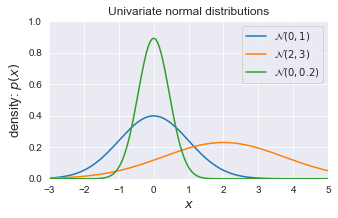

In [23]:
def univariate_normal(x, mean, variance):
    """pdf of the univariate normal distribution."""
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

x = np.linspace(-3, 5, num=150)
fig = plt.figure(figsize=(5, 3))
plt.plot(
    x, univariate_normal(x, mean=0, variance=1), 
    label="$\mathcal{N}(0, 1)$")
plt.plot(
    x, univariate_normal(x, mean=2, variance=3), 
    label="$\mathcal{N}(2, 3)$")
plt.plot(
    x, univariate_normal(x, mean=0, variance=0.2), 
    label="$\mathcal{N}(0, 0.2)$")
plt.xlabel('$x$', fontsize=13)
plt.ylabel('density: $p(x)$', fontsize=13)
plt.title('Univariate normal distributions')
plt.ylim([0, 1])
plt.xlim([-3, 5])
plt.legend(loc=1)
fig.subplots_adjust(bottom=0.15)
plt.show()

In [27]:
def multivariate_normal(x, d, mean, covariance):
    """pdf of the multivariate normal distribution."""
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * 
            np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [28]:
# Plot bivariate distribution
def generate_surface(mean, covariance, d):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x1[i,j]], [x2[i,j]]]), 
                d, mean, covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

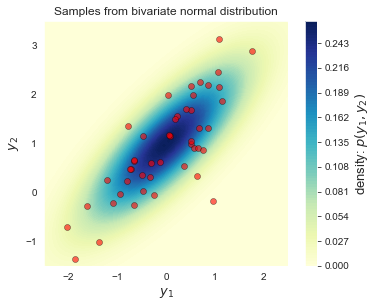

In [29]:
# Sample from:
d = 2 # Number of dimensions
mean = np.matrix([[0.], [1.]])
covariance = np.matrix([
    [1, 0.8], 
    [0.8, 1]
])

# Create L
L = np.linalg.cholesky(covariance)
# Sample X from standard normal
n = 50  # Samples to draw
X = np.random.normal(size=(d, n))
# Apply the transformation
Y = L.dot(X) + mean

fig, ax = plt.subplots(figsize=(6, 4.5))
# Plot bivariate distribution
x1, x2, p = generate_surface(mean, covariance, d)
con = ax.contourf(x1, x2, p, 100, cmap=cm.YlGnBu)
# Plot samples
ax.plot(Y[0,:], Y[1,:], 'ro', alpha=.6,
        markeredgecolor='k', markeredgewidth=0.5)
ax.set_xlabel('$y_1$', fontsize=13)
ax.set_ylabel('$y_2$', fontsize=13)
ax.axis([-2.5, 2.5, -1.5, 3.5])
ax.set_aspect('equal')
ax.set_title('Samples from bivariate normal distribution')
cbar = plt.colorbar(con)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=13)
plt.show()

In [30]:
d = 2  # dimensions
mean = np.matrix([[0.], [1.]])
cov = np.matrix([
    [1, 0.8], 
    [0.8, 1]
])

# Get the mean values from the vector
mean_x = mean[0,0]
mean_y = mean[1,0]
# Get the blocks (single values in this case) from 
#  the covariance matrix
A = cov[0, 0]
B = cov[1, 1]
C = cov[0, 1]  # = C transpose in this case

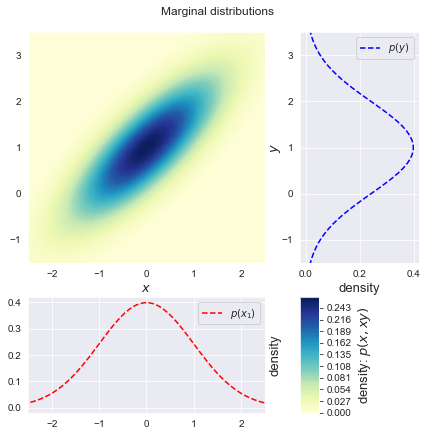

In [31]:
# Plot the conditional distributions
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)
plt.suptitle('Marginal distributions', y=0.93)

# Plot surface on top left
ax1 = plt.subplot(gs[0])
x, y, p = generate_surface(mean, cov, d)
# Plot bivariate distribution
con = ax1.contourf(x, y, p, 100, cmap=cm.YlGnBu)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.yaxis.set_label_position('right')
ax1.axis([-2.5, 2.5, -1.5, 3.5])

# Plot y
ax2 = plt.subplot(gs[1])
y = np.linspace(-5, 5, num=100)
py = univariate_normal(y, mean_y, A)
# Plot univariate distribution
ax2.plot(py, y, 'b--', label=f'$p(y)$')
ax2.legend(loc=0)
ax2.set_xlabel('density', fontsize=13)
ax2.set_ylim(-1.5, 3.5)

# Plot x
ax3 = plt.subplot(gs[2])
x = np.linspace(-5, 5, num=100)
px = univariate_normal(x, mean_x, B)
# Plot univariate distribution
ax3.plot(x, px, 'r--', label=f'$p(x_1)$')
ax3.legend(loc=0)
ax3.set_ylabel('density', fontsize=13)
ax3.yaxis.set_label_position('right')
ax3.set_xlim(-2.5, 2.5)

# Clear axis 4 and plot colarbar in its place
ax4 = plt.subplot(gs[3])
ax4.set_visible(False)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('left', size='20%', pad=0.05)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('density: $p(x, xy)$', fontsize=13)
plt.show()
#

In [32]:
# Calculate x|y
y_condition = 1.  # To condition on y
mean_xgiveny = mean_x + (C * (1/B) * (y_condition - mean_y))
cov_xgiveny = A - C * (1/B) * C

# Calculate y|x
x_condition = -1.  # To condition on x
mean_ygivenx = mean_y + (C * (1/A) * (x_condition - mean_x))
cov_ygivenx = B - (C * (1/A) * C)

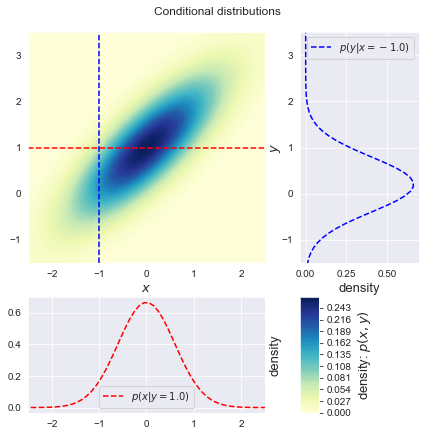

In [33]:
# Plot the conditional distributions
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 2, width_ratios=[2, 1], height_ratios=[2, 1])
# gs.update(wspace=0., hspace=0.)
plt.suptitle('Conditional distributions', y=0.93)

# Plot surface on top left
ax1 = plt.subplot(gs[0])
x, y, p = generate_surface(mean, cov, d)
# Plot bivariate distribution
con = ax1.contourf(x, y, p, 100, cmap=cm.YlGnBu)
# y=1 that is conditioned upon
ax1.plot([-2.5, 2.5], [y_condition, y_condition], 'r--')
# x=-1. that is conditioned upon
ax1.plot([x_condition, x_condition], [-1.5, 3.5], 'b--')
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.yaxis.set_label_position('right')
ax1.axis([-2.5, 2.5, -1.5, 3.5])

# Plot y|x
ax2 = plt.subplot(gs[1])
yx = np.linspace(-5, 5, num=100)
pyx = univariate_normal(yx, mean_ygivenx, cov_ygivenx)
# Plot univariate distribution
ax2.plot(pyx, yx, 'b--', 
         label=f'$p(y|x={x_condition:.1f})$')
ax2.legend(loc=0)
ax2.set_xlabel('density', fontsize=13)
ax2.set_ylim(-1.5, 3.5)

# Plot x|y
ax3 = plt.subplot(gs[2])
xy = np.linspace(-5, 5, num=100)
pxy = univariate_normal(xy, mean_xgiveny, cov_xgiveny)
# Plot univariate distribution
ax3.plot(xy, pxy, 'r--', 
         label=f'$p(x|y={y_condition:.1f})$')
ax3.legend(loc=0)
ax3.set_ylabel('density', fontsize=13)
ax3.yaxis.set_label_position('right')
ax3.set_xlim(-2.5, 2.5)

# Clear axis 4 and plot colarbar in its place
ax4 = plt.subplot(gs[3])
ax4.set_visible(False)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('left', size='20%', pad=0.05)
cbar = fig.colorbar(con, cax=cax)
cbar.ax.set_ylabel('density: $p(x, y)$', fontsize=13)
plt.show()
#